In [17]:
using LinearAlgebra
using Plots
using SharedArrays

In [18]:
include("../rollout.jl")
include("../testfns.jl")

TestLinearCosine1D (generic function with 3 methods)

In [19]:
function generate_initial_guesses(N::Int, lbs::Vector{T}, ubs::Vector{T},) where T <: Number
    ϵ = 1e-6
    seq = SobolSeq(lbs, ubs)
    initial_guesses = reduce(hcat, next!(seq) for i = 1:N)
    initial_guesses = hcat(initial_guesses, lbs .+ ϵ)
    initial_guesses = hcat(initial_guesses, ubs .- ϵ)

    return initial_guesses
end

generate_initial_guesses (generic function with 1 method)

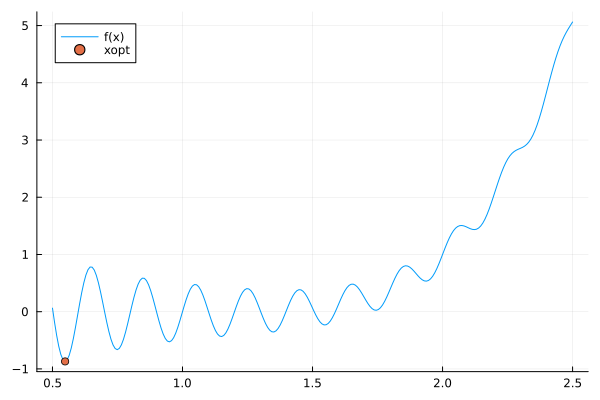

In [20]:
testfn = TestGramacyLee()
tplot(testfn)

In [21]:
n, h, σn2 = 1, 1, 1e-4
MC_SAMPLES = 50
NUMBER_OF_STARTS = 8
BATCH_SIZE = 8
# Setup low discrepancy random number stream
lds_rns = gen_low_discrepancy_sequence(MC_SAMPLES, testfn.dim, h+1);
rns = randn(MC_SAMPLES, testfn.dim+1, h+1);

xmin, xmax, d = (testfn.bounds[1], testfn.bounds[2], size(testfn.bounds, 1))
θ = [.25]
ψ = kernel_matern52(θ)

lbs, ubs = [xmin], [xmax]
ϵ, num_starts = 1e-6, 4
s = SobolSeq(lbs, ubs)

xstarts = reduce(hcat, next!(s) for i = 1:num_starts)
xstarts = hcat(xstarts, lbs .+ ϵ)
xstarts = hcat(xstarts, ubs .- ϵ);

In [22]:
X = [2.0528643649739697;; 0.5;; 0.5721383361452179;;0.6126151598810419;;1.3252074941253338;;1.4437436510695418;;1.6288360199191374;;1.5527882120548944;;1.5197060835176461;;1.482944874753541;;]
y = testfn(X)
sur = fit_surrogate(ψ, X, y; σn2=σn2)
sur = optimize_hypers_optim(sur, kernel_matern52);

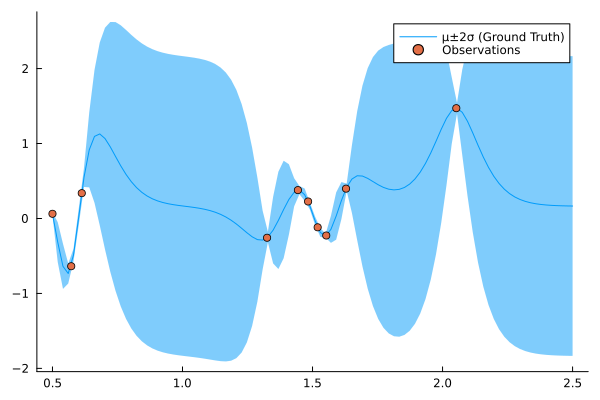

In [23]:
plot1D(sur, xmin=xmin, xmax=xmax)

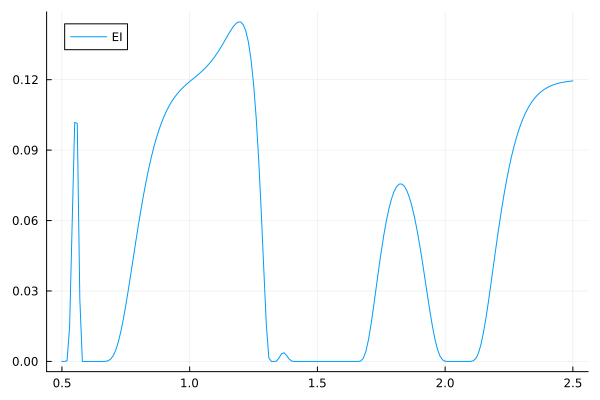

In [24]:
domain = xmin:.01:xmax
plot(domain, [sur([x]).EI for x in domain], label="EI")

In [25]:
tp = TrajectoryParameters(
        [1.5], # Will be overriden later
        h,
        MC_SAMPLES,
        lds_rns,
        lbs,
        ubs
);
# Allocate initial guesses for optimizer
initial_guesses = generate_initial_guesses(NUMBER_OF_STARTS, lbs, ubs);

# Initialize batch of points to evaluate the rollout acquisition function
batch = generate_batch(BATCH_SIZE, lbs=tp.lbs, ubs=tp.ubs)

# Setup shared arrays
candidate_locations = SharedMatrix{Float64}(testfn.dim, NUMBER_OF_STARTS)
candidate_values = SharedArray{Float64}(NUMBER_OF_STARTS);
αxs = SharedArray{Float64}(tp.mc_iters)
∇αxs = SharedMatrix{Float64}(testfn.dim, tp.mc_iters)
final_locations = SharedMatrix{Float64}(length(tp.x0), size(batch, 2))
final_evaluations = SharedArray{Float64}(size(batch, 2));

In [26]:
acqfunc = zeros(length(domain))

for (ndx, x) in enumerate(domain)
    print("|")
    tp.x0 = [x]
    μx, ∇μx, stderr_μx, stderr_∇μx = simulate_trajectory(sur, tp, initial_guesses;
        candidate_locations=candidate_locations,
        candidate_values=candidate_values,
        variance_reduction=true
    )
    acqfunc[ndx] = μx
end

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

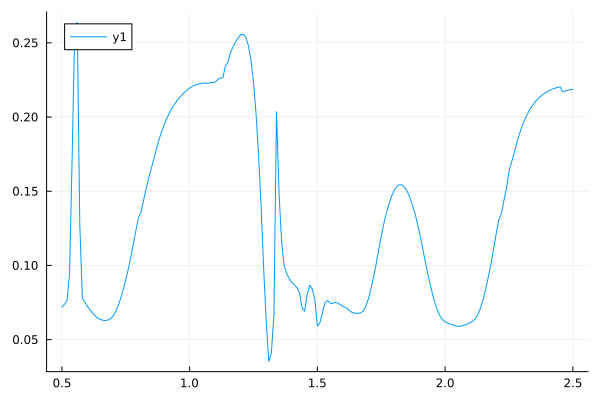

In [27]:
plot(domain, acqfunc)

In [28]:
@time res = distributed_rollout_solver(
    sur=sur, tp=tp, xstarts=initial_guesses, batch=batch, max_iterations=100,
    candidate_locations=candidate_locations, candidate_values=candidate_values,
    αxs=αxs, ∇αxs=∇αxs, final_locations=final_locations, final_evaluations=final_evaluations
)

 60.662950 seconds (547.84 M allocations: 29.733 GiB, 6.92% gc time, 0.33% compilation time)


([1.1958999069247678], 0.25502823955838216)

In [29]:
@time res = rollout_solver(
    sur=sur, tp=tp, xstarts=initial_guesses, batch=batch, max_iterations=100,
    candidate_locations=candidate_locations, candidate_values=candidate_values,
)

 64.115833 seconds (547.70 M allocations: 29.724 GiB, 6.62% gc time, 0.07% compilation time)


([1.1958999069247678], 0.25502823955838216)

In [ ]:
final_evaluations

In [ ]:
final_locations